In [7]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.transforms.v2.functional as F_v2
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from Utils.dataset import PreloadedDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from Deep_Learning.Representation_Learning.Methods.AugPC.train import train as train_augpc
from Deep_Learning.Representation_Learning.Methods.AugPC.model import AugPC
from Deep_Learning.Representation_Learning.Methods.LAugPC.train import train as train_laugpc
from Deep_Learning.Representation_Learning.Methods.SSMAugPC.model import SSMAugPC
from Deep_Learning.Representation_Learning.Methods.SSMAugPC.train import train as train_ssmaugpc
from Deep_Learning.Representation_Learning.Methods.LAugPC.model import LAugPC
from Deep_Learning.Representation_Learning.Methods.BYOL.train import train as train_byol
from Deep_Learning.Representation_Learning.Methods.BYOL.model import BYOL
from Deep_Learning.Representation_Learning.Methods.DINO.train import train as train_dino
from Deep_Learning.Representation_Learning.Methods.DINO.model import DINO
from Deep_Learning.Representation_Learning.Methods.SimCLR.train import train as train_simclr
from Deep_Learning.Representation_Learning.Methods.SimCLR.model import SimCLR
from Deep_Learning.Representation_Learning.Methods.SimSiam.train import train as train_simsiam
from Deep_Learning.Representation_Learning.Methods.SimSiam.model import SimSiam
from Deep_Learning.Representation_Learning.Methods.LAugPC2.train import train as train_laugpc2
from Deep_Learning.Representation_Learning.Methods.LAugPC2.model import LAugPC2
# from Deep_Learning.Representation_Learning.Methods.VQVAE.train import train as train_vae
# from Deep_Learning.Representation_Learning.Methods.VQVAE.model import VAE
from Deep_Learning.Representation_Learning.Methods.AE.train import train as train_ae
from Deep_Learning.Representation_Learning.Methods.AE.model import AE
from Deep_Learning.Representation_Learning.Methods.VAE.train import train as train_vae
from Deep_Learning.Representation_Learning.Methods.VAE.model import VAE

from Deep_Learning.Representation_Learning.Examples.MNIST.mnist_linear_1k import mnist_linear_1k_eval
from Deep_Learning.Representation_Learning.Utils.functional import get_optimiser

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True
device

device(type='cuda')

In [9]:
dataset = datasets.MNIST(root='../Datasets/', train=True, transform=transforms.ToTensor(), download=True)
t_dataset = datasets.MNIST(root='../Datasets/', train=False, transform=transforms.ToTensor(), download=True)

VAL_RATIO = 0.2
n_val = int(len(dataset) * VAL_RATIO)
n_train = len(dataset) - n_val
train_set, val_set = torch.utils.data.random_split(dataset, [n_train, n_val])



train_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Pad(2),
    # transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform(),
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Pad(2),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform()
])
augmentation = transforms.Compose([
    transforms.RandomCrop(20),
    transforms.Resize(28, interpolation=transforms.InterpolationMode.NEAREST),
    # transforms.RandomAffine(degrees=180, translate=(0.28, 0.28), scale=(0.75, 1.25), shear=25),
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.75, 1.25), shear=25),
    # transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
])

train_set = PreloadedDataset.from_dataset(train_set, train_transform, device)
val_set = PreloadedDataset.from_dataset(val_set, val_transform, device)
test_set = PreloadedDataset.from_dataset(t_dataset, val_transform, device)


  0%|          | 0/48000 [00:00<?, ?it/s]

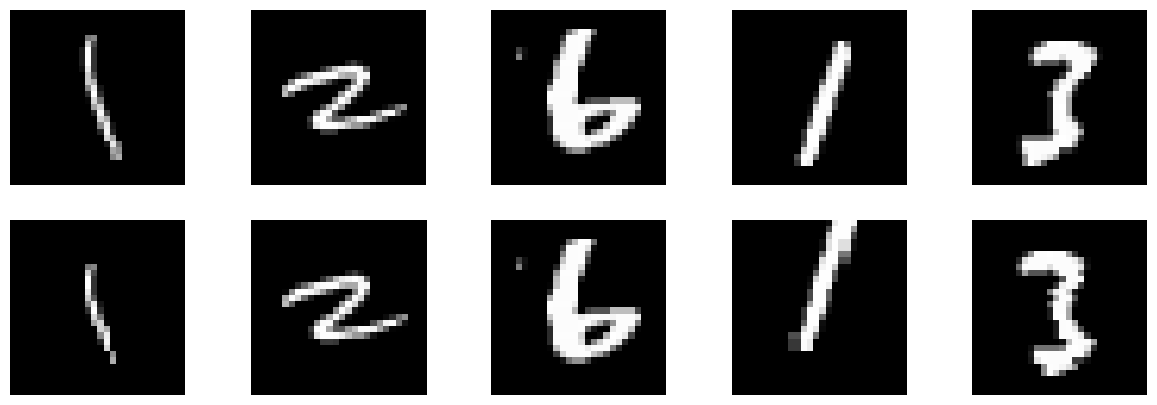

Max value: tensor(1., device='cuda:0')
Min value: tensor(0., device='cuda:0')


In [10]:
# Show example images
# fig, axes = plt.subplots(1, 10, figsize=(15,5))
# for i, ax in enumerate(axes):
#     img, label = train_set[i]
#     angle = torch.rand(1).item() * 360 - 180 if torch.rand(1).item() > 0.75 else 0
#     translate_x = torch.randint(-8, 9, (1,)).item() if torch.rand(1).item() > 0.75 else 0
#     translate_y = torch.randint(-8, 9, (1,)).item() if torch.rand(1).item() > 0.75 else 0
#     scale = torch.rand(1).item() * 0.5 + 0.75 if torch.rand(1).item() > 0.75 else 1.0
#     shear = torch.rand(1).item() * 50 - 25 if torch.rand(1).item() > 0.75 else 0
#     img = F_v2.affine(img, angle=angle, translate=(translate_x, translate_y), scale=scale, shear=shear)
#     ax.imshow(img.squeeze().cpu(), cmap='gray')
#     ax.set_title(f"Label: {label}")
#     ax.axis('off')
# plt.show()

# show before and after on each row
fig, axes = plt.subplots(2, 5, figsize=(15,5))
for i, ax in enumerate(axes[0]):
    img, label = train_set[i+20]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axes[1]):
    img, label = train_set[i+20]
    angle = torch.rand(1).item() * 360 - 180 if torch.rand(1).item() > 0.75 else 0
    translate_x = torch.randint(-8, 9, (1,)).item() if torch.rand(1).item() > 0.75 else 0
    translate_y = torch.randint(-8, 9, (1,)).item() if torch.rand(1).item() > 0.75 else 0
    scale = torch.rand(1).item() * 0.5 + 0.75 if torch.rand(1).item() > 0.75 else 1.0
    shear = torch.rand(1).item() * 50 - 25 if torch.rand(1).item() > 0.75 else 0
    img = F_v2.affine(img, angle=angle, translate=(translate_x, translate_y), scale=scale, shear=shear)
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()



# print max and min values
print('Max value:', train_set.transformed_images.max())
print('Min value:', train_set.transformed_images.min())

In [12]:
cfgs = [
    {
        'name': 'AugPC',
    },
]


for cfg in cfgs:

    Model = AugPC
    # backbone = 'mnist_cnn'
    backbone='mnist_cnn'
    experiment_name = cfg['name']
    experiment = 'pc_vs_ae1'
    # experiment = 'LAugPC-loss'
    log_dir = f'Deep_Learning/Representation_Learning/Examples/MNIST/out/logs/{experiment}/{experiment_name}/'
    log_dir = None
    save_dir = f'Deep_Learning/Representation_Learning/Examples/MNIST/out/models/{experiment}/{experiment_name}.pth'
    # save_dir = None
    model = Model(1, 5,
                backbone=backbone, 
                ).to(device)

    optimiser = get_optimiser(
        model, 
        'AdamW', 
        # lr = cfg['lr'],
        lr=3e-4, 
        wd=0.004, 
        exclude_bias=True,
        exclude_bn=True,
    )

    to_train = True
    if save_dir is not None:
        try:
            sd = torch.load(save_dir)
            # change keys "project" to "transition"
            for key in list(sd.keys()):
                if 'project' in key:
                    sd[key.replace('project', 'transition')] = sd.pop(key)
            model.load_state_dict(sd)
            to_train = False
            print('Model loaded successfully')
        except FileNotFoundError:
            pass
            print('Model not found, training new model')
    if to_train:
        writer = None
        if log_dir is not None:
            # remove reduction if exists
            if os.path.exists(log_dir + 'encoder/reduction.csv'):
                os.remove(log_dir + 'encoder/reduction.csv')
            if os.path.exists(log_dir + 'classifier/reduction.csv'):
                os.remove(log_dir + 'classifier/reduction.csv')

            run_no = 1
            while os.path.exists(log_dir + 'encoder/' + f'run_{run_no}'):
                run_no += 1
            writer = SummaryWriter(log_dir + 'encoder/' + f'run_{run_no}')

        if isinstance(model, LAugPC):
            train_laugpc(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                train_aug_scaler='none',
                val_aug_scaler='none',
                start_tau=0.996,
                end_tau=1.0,
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )

        if isinstance(model, AugPC):
            train_augpc(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=None,
                train_aug_scaler='none',
                val_aug_scaler='none',
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, SSMAugPC):
            train_augpc(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=None,
                train_aug_scaler='none',
                val_aug_scaler='none',
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, BYOL):
            train_byol(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                augmentation=augmentation,
                beta=None,
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, VAE):
            train_vae(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=0.75,
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, AE):
            train_ae(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=None,
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, DINO):
            train_dino(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                augmentation=augmentation,
                scale_temps=2.0,
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        print(f'Finished training')
        if save_dir is not None:
            print('Run cell again to load best (val_acc) model.')

    # collect 100 of each target index from train_set.targets
    writer = SummaryWriter(log_dir + f'classifier/run_{run_no}')
    mnist_linear_1k_eval(model, writer, flatten=False)

Model not found, training new model


Finished training
Run cell again to load best (val_acc) model.


TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

In [6]:
cfgs = [
    {
        'name': 'proj',
    },
    {
        'name': 'proj',
    },
]


for cfg in cfgs:

    Model = LAugPC
    # backbone = 'mnist_cnn'
    backbone='mnist_cnn'
    experiment_name = cfg['name']
    # experiment = 'pc_vs_ae1'
    experiment = 'LAugPC-C-mom'
    log_dir = f'Deep_Learning/Representation_Learning/Examples/MNIST/out/logs/{experiment}/{experiment_name}/'
    save_dir = f'Deep_Learning/Representation_Learning/Examples/MNIST/out/models/{experiment}/{experiment_name}.pth'
    save_dir = None
    model = Model(1, 5,
                backbone=backbone, 
                ).to(device)

    optimiser = get_optimiser(
        model, 
        'AdamW', 
        # lr = cfg['lr'],
        lr=3e-4, 
        wd=0.004, 
        exclude_bias=True,
        exclude_bn=True,
    )

    to_train = True
    if save_dir is not None:
        try:
            sd = torch.load(save_dir)
            # change keys "project" to "transition"
            for key in list(sd.keys()):
                if 'project' in key:
                    sd[key.replace('project', 'transition')] = sd.pop(key)
            model.load_state_dict(sd)
            to_train = False
            print('Model loaded successfully')
        except FileNotFoundError:
            pass
            print('Model not found, training new model')
    if to_train:
        writer = None
        if log_dir is not None:
            # remove reduction if exists
            if os.path.exists(log_dir + 'encoder/reduction.csv'):
                os.remove(log_dir + 'encoder/reduction.csv')
            if os.path.exists(log_dir + 'classifier/reduction.csv'):
                os.remove(log_dir + 'classifier/reduction.csv')

            run_no = 1
            while os.path.exists(log_dir + 'encoder/' + f'run_{run_no}'):
                run_no += 1
            writer = SummaryWriter(log_dir + 'encoder/' + f'run_{run_no}')

        if isinstance(model, LAugPC):
            train_laugpc(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                train_aug_scaler='none',
                val_aug_scaler='none',
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )

        if isinstance(model, AugPC):
            train_augpc(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=None,
                train_aug_scaler='none',
                val_aug_scaler='none',
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, SSMAugPC):
            train_augpc(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=None,
                train_aug_scaler='none',
                val_aug_scaler='none',
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, BYOL):
            train_byol(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                augmentation=augmentation,
                beta=None,
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, VAE):
            train_vae(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=0.75,
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, AE):
            train_ae(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=None,
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, DINO):
            train_dino(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                augmentation=augmentation,
                scale_temps=2.0,
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        print(f'Finished training')
        if save_dir is not None:
            print('Run cell again to load best (val_acc) model.')

    # collect 100 of each target index from train_set.targets
    writer = SummaryWriter(log_dir + f'classifier/run_{run_no}')
    mnist_linear_1k_eval(model, writer, flatten=False)

Finished training


Best validation accuracy: 0.9099999666213989


Finished training


Best validation accuracy: 0.9078999757766724


In [ ]:
cfgs = [
    {
    },
    {
    },
    {
    }
]


for cfg in cfgs:

    Model = LAugPC
    # backbone = 'mnist_cnn'
    backbone='mnist_cnn'
    experiment_name = 'LAugPC'
    experiment = 'pc_vs_ae1'
    log_dir = f'Deep_Learning/Representation_Learning/Examples/MNIST/out/logs/{experiment}/{experiment_name}/'
    save_dir = f'Deep_Learning/Representation_Learning/Examples/MNIST/out/models/{experiment}/{experiment_name}.pth'
    save_dir = None
    model = Model(1, 5,
                backbone=backbone, 
                ).to(device)

    optimiser = get_optimiser(
        model, 
        'AdamW', 
        # lr = cfg['lr'],
        lr=3e-4, 
        wd=0.004, 
        exclude_bias=True, 
        exclude_bn=True
    )

    to_train = True
    if save_dir is not None:
        try:
            sd = torch.load(save_dir)
            # change keys "project" to "transition"
            for key in list(sd.keys()):
                if 'project' in key:
                    sd[key.replace('project', 'transition')] = sd.pop(key)
            model.load_state_dict(sd)
            to_train = False
            print('Model loaded successfully')
        except FileNotFoundError:
            pass
            print('Model not found, training new model')
    if to_train:
        writer = None
        if log_dir is not None:
            # remove reduction if exists
            if os.path.exists(log_dir + 'encoder/reduction.csv'):
                os.remove(log_dir + 'encoder/reduction.csv')
            if os.path.exists(log_dir + 'classifier/reduction.csv'):
                os.remove(log_dir + 'classifier/reduction.csv')

            run_no = 1
            while os.path.exists(log_dir + 'encoder/' + f'run_{run_no}'):
                run_no += 1
            writer = SummaryWriter(log_dir + 'encoder/' + f'run_{run_no}')

        if isinstance(model, LAugPC):
            train_laugpc(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                train_aug_scaler='none',
                val_aug_scaler='none',
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )

        if isinstance(model, AugPC):
            train_augpc(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=None,
                train_aug_scaler='none',
                val_aug_scaler='none',
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, SSMAugPC):
            train_augpc(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=None,
                train_aug_scaler='none',
                val_aug_scaler='none',
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, DAugPC):
            train_daugpc(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=None,
                train_aug_scaler='none',
                val_aug_scaler='none',
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, BYOL):
            train_byol(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                augmentation=augmentation,
                beta=None,
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, VAE):
            train_vae(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=0.75,
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, AE):
            train_ae(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=None,
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, DINO):
            train_dino(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                augmentation=augmentation,
                scale_temps=2.0,
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        print(f'Finished training')
        if save_dir is not None:
            print('Run cell again to load best (val_acc) model.')

    # collect 100 of each target index from train_set.targets
    writer = SummaryWriter(log_dir + f'classifier/run_{run_no}')
    mnist_linear_1k_eval(model, writer, flatten=False)

ValueError: NaN Loss after normalisation, Exiting Training

In [ ]:
Model = VAugPC
# backbone = 'mnist_cnn'
backbone='mnist_cnn'
# experiment_name = f'{Model.__name__}-{backbone}'
experiment_name = f'VAugPC'
# experiment = 'pc_vs_ae'
experiment = 'pc_vs_ae1'
log_dir = f'Deep_Learning/Representation_Learning/Examples/MNIST/out/logs/{experiment}/{experiment_name}/'
save_dir = f'Deep_Learning/Representation_Learning/Examples/MNIST/out/models/{experiment}/{experiment_name}.pth'
# log_dir = None
save_dir = None
model = Model(1, 5, backbone=backbone).to(device)
# model = Model(1, backbone).to(device)
# model = Model(1, backbone=backbone).to(device)

optimiser = get_optimiser(
    model, 
    'AdamW', 
    # lr=3e-4, 
    # lr=3e-5, 
    lr=0.0003,
    wd=0.004, 
    exclude_bias=True, 
    exclude_bn=True
)

In [ ]:
to_train = True
if save_dir is not None:
    try:
        sd = torch.load(save_dir)
        # change keys "project" to "transition"
        for key in list(sd.keys()):
            if 'project' in key:
                sd[key.replace('project', 'transition')] = sd.pop(key)
        model.load_state_dict(sd)
        to_train = False
        print('Model loaded successfully')
    except FileNotFoundError:
        pass
        print('Model not found, training new model')
if to_train:
    writer = None
    if log_dir is not None:
        writer = SummaryWriter(log_dir)

    if isinstance(model, AugPC):
        train_augpc(
            model,
            optimiser,
            train_set,
            val_set,
            num_epochs=250,
            batch_size=256,
            beta=None,
            train_aug_scaler='none',
            val_aug_scaler='none',
            learn_on_ss=False,
            writer=writer,
            save_dir=save_dir,
            save_every=5,
        )
    if isinstance(model, VAugPC):
        train_vaugpc(
            model,
            optimiser,
            train_set,
            val_set,
            num_epochs=250,
            batch_size=256,
            beta=None,
            train_aug_scaler='none',
            val_aug_scaler='none',
            learn_on_ss=False,
            writer=writer,
            save_dir=save_dir,
            save_every=5,
        )
    if isinstance(model, LAugPC):
        train_laugpc(
            model,
            optimiser,
            train_set,
            val_set,
            num_epochs=500,
            batch_size=256,
            train_aug_scaler='none',
            val_aug_scaler='none',
            learn_on_ss=False,
            writer=writer,
            save_dir=save_dir,
            save_every=5,
        )

    if isinstance(model, LAugPC2):
        train_laugpc2(
            model,
            optimiser,
            train_set,
            val_set,
            num_epochs=500,
            batch_size=256,
            beta=None,
            aug_scaler='none',
            use_target_model=False,
            weights=None,
            learn_on_ss=False,
            writer=writer,
            save_dir=save_dir,
            save_every=5,
        )

    if isinstance(model, BYOL):
        train_byol(
            model,
            optimiser,
            train_set,
            val_set,
            num_epochs=500,
            batch_size=256,
            augmentation=augmentation,
            beta=None,
            tau_0=0.996,
            tau_e=0.999,
            tau_T=100,
            normalise=True,
            learn_on_ss=False,
            writer=writer,
            save_dir=save_dir,
            save_every=5,
        )
    if isinstance(model, DINO):
        train_dino(
            model,
            optimiser,
            train_set,
            val_set,
            num_epochs=250,
            batch_size=256,
            augmentation=augmentation,
            scale_temps=2.0,
            learn_on_ss=False,
            writer=writer,
            save_dir=save_dir,
            save_every=5,
        )

    if isinstance(model, SimSiam):
        train_simsiam(
            model,
            optimiser,
            train_set,
            val_set,
            num_epochs=500,
            batch_size=256,
            augmentation=augmentation,
            beta=None,
            learn_on_ss=False,
            writer=writer,
            save_dir=save_dir,
            save_every=5,
        )

    if isinstance(model, SimCLR):
        train_simclr(
            model,
            optimiser,
            train_set,
            val_set,
            num_epochs=500,
            batch_size=256,
            temperature=1.0,
            augmentation=augmentation,
            writer=writer,
            save_dir=save_dir,
            save_every=5,
        )
    
    # if isinstance(model, VAE):
    #     train_vae(
    #         model,
    #         optimiser,
    #         train_set,
    #         val_set,
    #         num_epochs=500,
    #         batch_size=32,
    #         learn_on_ss=False,
    #         writer=writer,
    #         save_dir=save_dir,
    #         save_every=5,
    #     )

    print(f'Finished training')
    if save_dir is not None:
        print('Run cell again to load best (val_acc) model.')

Finished training


In [ ]:
# collect 100 of each target index from train_set.targets
writer = SummaryWriter(log_dir)
mnist_linear_1k_eval(model, writer, flatten=False)

Best validation accuracy: 0.967799961566925


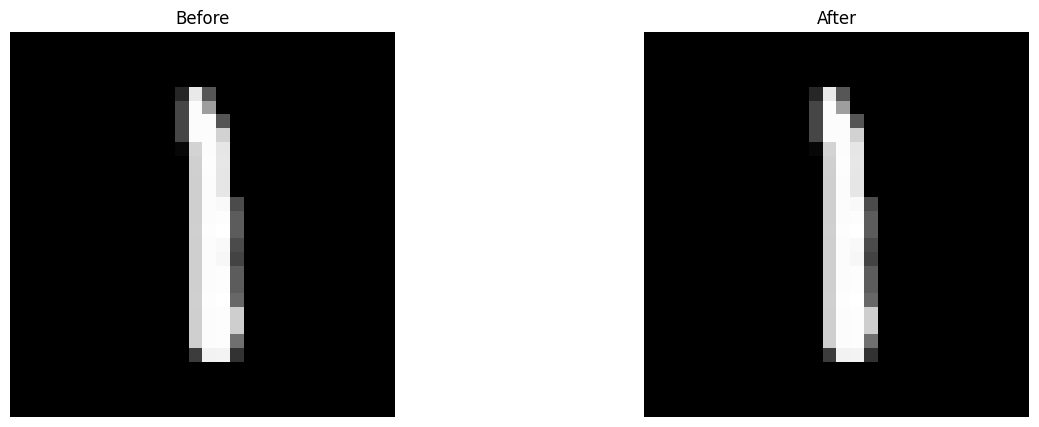

In [ ]:
img_before = train_set[0][0].unsqueeze(0)
img_after = F_v2.affine(img, angle=0, translate=(0, 0), scale=1.0, shear=0)

# Show example images
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img_before.squeeze().cpu(), cmap='gray')
axes[0].set_title(f"Before")
axes[0].axis('off')
axes[1].imshow(img_after.squeeze().cpu(), cmap='gray')
axes[1].set_title(f"After")
axes[1].axis('off')
plt.show()

In [14]:
img = train_set[4][0].unsqueeze(0)
model.eval()

def compare(model, img, angle, translate_x, translate_y, scale, shear):
    img_aug = F_v2.affine(img, angle=angle, translate=(translate_x, translate_y), scale=scale, shear=shear)
    action = torch.tensor([angle/180, translate_x/8, translate_y/8, (scale-1.0)/0.25, shear/25], dtype=torch.float32, device=img.device).unsqueeze(0).repeat(img.shape[0], 1)
    # img_pred = model.predict(img, action)
    img_pred = model.predict(img.flatten(1), action).view(img.shape)
    loss = F.mse_loss(img_aug, img_pred)
    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    axes[0].imshow(img.squeeze().cpu(), cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')
    axes[1].imshow(img_aug.squeeze().cpu(), cmap='gray')
    axes[1].set_title('Augmented')
    axes[1].axis('off')
    axes[2].imshow(img_pred.squeeze().cpu().detach(), cmap='gray')
    axes[2].set_title('Predicted')
    axes[2].axis('off')
    plt.show()
    return loss.item()

interact(compare, model=fixed(model), img=fixed(img), angle=(-180, 180), translate_x=(-8, 8), translate_y=(-8, 8), scale=(0.75, 1.25), shear=(-25, 25))


interactive(children=(IntSlider(value=0, description='angle', max=180, min=-180), IntSlider(value=0, descripti…

<function __main__.compare(model, img, angle, translate_x, translate_y, scale, shear)>

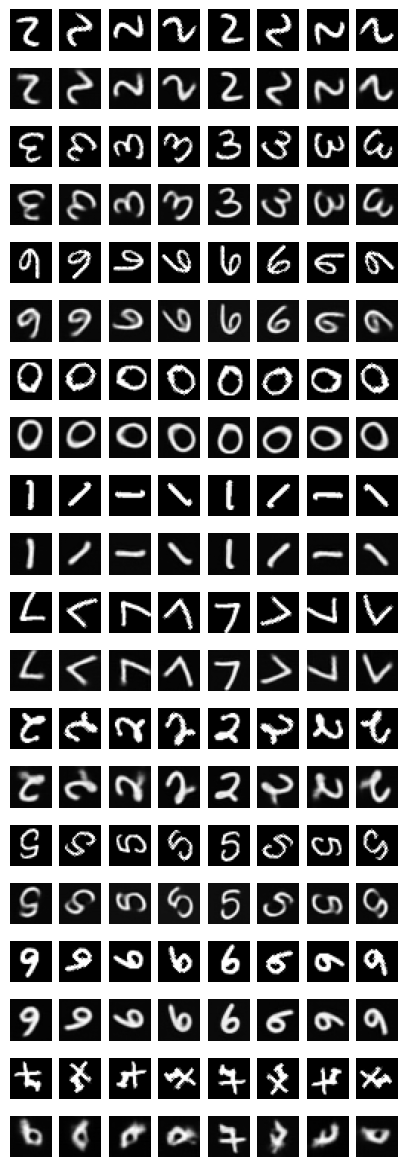

In [28]:
# collect 1 img of each digit
images = []
for i in range(10):
    while len(images) < i+1:
        idx = torch.randint(0, len(test_set), (1,)).item()
        if test_set.targets[idx] == i:
            images.append(train_set[idx][0].unsqueeze(0))

angles = torch.arange(-180, 180, 45).tolist()
translate = (0,0)
scale = 1.0
shear = 0.0

truth = {}
pred = {}

for i in range(10):
    images_aug = []
    img_preds = []
    for angle in angles:
        img_aug = F_v2.affine(images[i], angle=angle, translate=translate, scale=scale, shear=shear)
        action = torch.tensor([angle/180, translate_x/8, translate_y/8, (scale-1.0)/0.25, shear/25], dtype=torch.float32, device=img.device).unsqueeze(0).repeat(img.shape[0], 1)
        images_aug.append(img_aug)
        img_preds.append(model.predict(images[i], action).view(images[i].shape))
    
    truth[i] = images_aug
    pred[i] = img_preds

# Show example images
fig, axes = plt.subplots(20, 8, figsize=(5,15))
for i in range(10):
    for j in range(8):
        axes[2*i, j].imshow(truth[i][j].squeeze().cpu(), cmap='gray')
        axes[2*i, j].axis('off')
        axes[2*i+1, j].imshow(pred[i][j].squeeze().cpu().detach()
                              , cmap='gray')
        axes[2*i+1, j].axis('off')

